In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from src.utils.visualization import plot_comparison_histogram
from src.utils.evaluation import evaluate
from src.utils.transform import (HourExtractor, WeekendExtractor, 
    FeatureCrosser, FringeCategoryBucketer)
from src.models.baseline import BaselineClassifier

In [3]:
cfg = OmegaConf.load('../config.yaml')

In [4]:
processed_data_dir = '..' / pathlib.Path(cfg.paths.data.processed)
processed_file = processed_data_dir / cfg.files.processed_dataset

df = pd.read_csv(processed_file)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38182 entries, 0 to 38181
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             33983 non-null  float64
 1   long            33983 non-null  float64
 2   download_mbit   38182 non-null  float64
 3   upload_mbit     38182 non-null  float64
 4   ping_ms         38180 non-null  float64
 5   platform        38182 non-null  object 
 6   network_name    24556 non-null  object 
 7   time_utc        38182 non-null  object 
 8   cat_technology  38182 non-null  object 
dtypes: float64(5), object(4)
memory usage: 2.6+ MB


## Train Test Split

In [6]:
X = df.copy()
y = X.pop(cfg.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

## Baseline Model

In [7]:
# We define upper limits for download speed
# as thresholds for the baseline model.
# E.g., if download-speed is less than
# 20 mbit/s, we assume its 3G,
# if it is between 20 and 150 mbit/s
# we say 4G, and beyond that we will return 5G
upper_limits = {
    '3G': 20,
    '4G': 150,
}

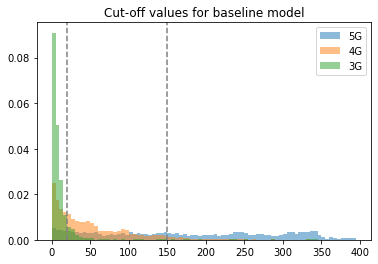

In [8]:
plot_comparison_histogram(
    X_train.download_mbit,
    y_train,
    bins=np.arange(0,400,5),
    vlines=upper_limits.values(),
    title='Cut-off values for baseline model'
)

In [9]:
baseline = BaselineClassifier(col_index=2,
                              upper_limits=upper_limits)

baseline.fit(X_train, y_train)

y_test_baseline = baseline.predict(X_test)

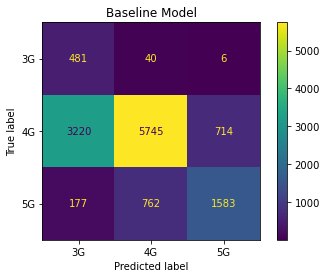

              precision    recall  f1-score   support

          3G       0.12      0.91      0.22       527
          4G       0.88      0.59      0.71      9679
          5G       0.69      0.63      0.66      2522

    accuracy                           0.61     12728
   macro avg       0.56      0.71      0.53     12728
weighted avg       0.81      0.61      0.68     12728

AVG PRECISION: 0.563 (macro)
AVG RECALL: 0.711 (macro)
AVG F1: 0.528 (macro)


In [11]:
evaluate(y_test, y_test_baseline, title='Baseline Model', average='macro')